# Determining ERA5 climatology

## ERA5 climatology for deepsoiltemperture CCLM
Problem:
T_Cl in the extpar of cclm is (presumably) the reason for the cold bias in all cclm runs.
Therefore, we are investigating how other datasets could contribute to a smaller cold bias.

==> Current to do:
- Determine climatology of ERA5 soil layer 4
- Average, mean, max over 30 year periods
- Comparison with GLOBECOVER extpar and ECOCLIMAP extpar

In [1]:
import sys
parent_directory = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/fiens/ValEnsPy/evaluation_cclm/'
sys.path.append(parent_directory)
functions_directory = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/fiens/ValEnsPy/src/valenspy/'
sys.path.append(functions_directory)

from pathlib import Path

import xarray as xr
import pandas as pd

import valenspy as vp #The Valenspy package
from valenspy.inputconverter_functions import ERA5_to_CF, CCLM_to_CF
from valenspy._utilities import load_xarray_from_data_sources
from valenspy._regions import sel_region
from diagnostic_visualizations import *
from eval_functions import *
from yaml import safe_load

import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cf_xarray'

In [ ]:
def geo_to_rot(coord, ds):
    ###
    # Converts a geographic (lon,lat) point to an (rlon,rlat) point
    # => coord: geographic lon - lat couple (degrees) => list or tuple
    # => ds: xarray dataset of a CCLM file
    ###
    # Read in COSMO-CLM data

    rp_lat = float(ds.rotated_pole.grid_north_pole_latitude)
    rp_lon = float(ds.rotated_pole.grid_north_pole_longitude)
    # Convert 
    co = np.deg2rad(coord)
    rp_lat = np.deg2rad(rp_lat); rp_lon = np.deg2rad(rp_lon)
    p_rlat = np.arcsin(np.sin(co[1])*np.sin(rp_lat) + np.cos(co[1])*np.cos(rp_lat)*np.cos(co[0]-rp_lon)) 
    p_rlon = np.arctan((np.cos(co[1])*np.sin(co[0]-rp_lon)) / (np.cos(co[1])*np.sin(rp_lat)*np.cos(co[0]-rp_lon) - np.sin(co[1])*np.cos(rp_lat))) 
    p_rlat = np.rad2deg(p_rlat); p_rlon = np.rad2deg(p_rlon)
    # Return rlon-rlat couple
    return [p_rlon,p_rlat]

In [ ]:
machine = "hortense"
variable = "stl4"
ref_dataset = "ERA5"
startyear = 1961
endyear = 1990
method = 'min'

In [ ]:
# Loading ECOCLIMAP data
ec_dir = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/wouterl/exp_fiens_eval_setup_JJA1995_transient_aerosol_ECOCLIMAP/ext/'
ec_file = ec_dir + 'extpar_1995.nc'
ec_extp = xr.open_mfdataset(ec_file, combine="by_coords", chunks="auto")


In [ ]:
# Loading ECOCLIMAP data
gc_dir = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/wouterl/exp_fiens_eval_setup_JJA1995_transient_aerosol/ext/'
gc_file = gc_dir + 'extpar_1995.nc'
gc_extp = xr.open_mfdataset(gc_file, combine="by_coords", chunks="auto")

In [ ]:
# ERA5 files (manually loaded and converted)
data_dir = '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/soil_temperature_level_4/'
ERA5_deepsoil_files = os.listdir(data_dir)


In [ ]:
# Processing data into file with averages
# Filtering climatology files based on year range
climatology_files = [
    s for s in ERA5_deepsoil_files 
    if startyear <= int(s[-7:-3]) <= endyear
]
#climatology_files = ','.join(climatology_files)


In [ ]:
# Calculating climatology statistics
# List all NetCDF files in the directory
netcdf_files = [os.path.join(data_dir, f) for f in climatology_files]
# Open multiple NetCDF files as a single xarray dataset
ds = xr.open_mfdataset(netcdf_files, combine='by_coords', engine='netcdf4', chunks="auto")



In [ ]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

In [ ]:
# region = 'belgium'
# lat_bounds = bounds[region]['lat_bounds']
# lon_bounds = bounds[region]['lon_bounds']
ds = ds.rename({'latitude' : 'lat', 'longitude' : 'lon', 'valid_time' : 'time'})
# da = ds.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))
da = ds


In [ ]:
savepath = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/ERA5/'
print(method)
filename = ref_dataset + '_' + variable + '_' + str(startyear) + '-' + str(endyear) + '_' + method + '.nc'
if os.path.exists(savepath + filename):
    print(f"The file '{filename}' already exists.")
    ds = xr.open_mfdataset(savepath + filename)
    da = ds.to_array()
else:
    if method == 'min':
        print('min')
        da = ds['stl4'].min('time').compute()
    elif method == 'mean':
        da = ds['stl4'].mean('time').compute()
    elif method == 'max':
        da = ds['stl4'].max('time').compute()
    elif method == 'P10':
        da = ds['stl4'].quantile(q = 10, dim = 'time').compute()
    else:
        print("Method is not included")
    da.to_netcdf(savepath + filename)


#plot_map(da)

min
The file 'ERA5_stl4_1961-1990_min.nc' already exists.


In [ ]:
da

<xarray.DataArray (variable: 1, lat: 163, lon: 289)> Size: 188kB
dask.array<stack, shape=(1, 163, 289), dtype=float32, chunksize=(1, 163, 289), chunktype=numpy.ndarray>
Coordinates:
    number    int64 8B ...
  * lat       (lat) float64 1kB 73.5 73.25 73.0 72.75 ... 33.75 33.5 33.25 33.0
  * lon       (lon) float64 2kB -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * variable  (variable) object 8B 'stl4'

In [ ]:
gridfile = data_dir + climatology_files[0]
da_ec_extp_soil = ec_extp["T_CL"]
ec_remap = remap_cdo(ds = da_ec_extp_soil, target_grid = gridfile, remap_method="bil")


In [ ]:
ec_remap.attrs['long_name'] = 'Deepsoil Temperature'
ec_remap.attrs['units'] = 'K'
ec_remap.attrs['dataset'] = 'CRU'
da_ec_remap = ec_remap.to_array()
da.attrs['dataset'] = method + ' ERA5 level4'

In [ ]:
da

<xarray.DataArray (variable: 1, lat: 163, lon: 289)> Size: 188kB
dask.array<stack, shape=(1, 163, 289), dtype=float32, chunksize=(1, 163, 289), chunktype=numpy.ndarray>
Coordinates:
    number    int64 8B ...
  * lat       (lat) float64 1kB 73.5 73.25 73.0 72.75 ... 33.75 33.5 33.25 33.0
  * lon       (lon) float64 2kB -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * variable  (variable) object 8B 'stl4'
Attributes:
    dataset:  min ERA5 level4

In [ ]:
region = 'belgium'
lat_bounds = bounds[region]['lat_bounds']
lon_bounds = bounds[region]['lon_bounds']
da_region = sel_region(da, region=region)
da['lat']

da_ec_remap_region = sel_region(da_ec_remap, region=region)


<xarray.DataArray 'lat' (lat: 163)> Size: 1kB
array([73.5 , 73.25, 73.  , 72.75, 72.5 , 72.25, 72.  , 71.75, 71.5 , 71.25,
       71.  , 70.75, 70.5 , 70.25, 70.  , 69.75, 69.5 , 69.25, 69.  , 68.75,
       68.5 , 68.25, 68.  , 67.75, 67.5 , 67.25, 67.  , 66.75, 66.5 , 66.25,
       66.  , 65.75, 65.5 , 65.25, 65.  , 64.75, 64.5 , 64.25, 64.  , 63.75,
       63.5 , 63.25, 63.  , 62.75, 62.5 , 62.25, 62.  , 61.75, 61.5 , 61.25,
       61.  , 60.75, 60.5 , 60.25, 60.  , 59.75, 59.5 , 59.25, 59.  , 58.75,
       58.5 , 58.25, 58.  , 57.75, 57.5 , 57.25, 57.  , 56.75, 56.5 , 56.25,
       56.  , 55.75, 55.5 , 55.25, 55.  , 54.75, 54.5 , 54.25, 54.  , 53.75,
       53.5 , 53.25, 53.  , 52.75, 52.5 , 52.25, 52.  , 51.75, 51.5 , 51.25,
       51.  , 50.75, 50.5 , 50.25, 50.  , 49.75, 49.5 , 49.25, 49.  , 48.75,
       48.5 , 48.25, 48.  , 47.75, 47.5 , 47.25, 47.  , 46.75, 46.5 , 46.25,
       46.  , 45.75, 45.5 , 45.25, 45.  , 44.75, 44.5 , 44.25, 44.  , 43.75,
       43.5 , 43.25, 43.  , 42.75, 42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25,
       41.  , 40.75, 40.5 , 40.25, 40.  , 39.75, 39.5 , 39.25, 39.  , 38.75,
       38.5 , 38.25, 38.  , 37.75, 37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25,
       36.  , 35.75, 35.5 , 35.25, 35.  , 34.75, 34.5 , 34.25, 34.  , 33.75,
       33.5 , 33.25, 33.  ])
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 1kB 73.5 73.25 73.0 72.75 ... 33.75 33.5 33.25 33.0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [ ]:
diff_ec = da - da_ec_remap
diff_ec


<xarray.DataArray (variable: 0, lat: 0, lon: 21)> Size: 0B
dask.array<sub, shape=(0, 0, 21), dtype=float32, chunksize=(0, 0, 21), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 0B 
  * lon       (lon) float64 168B 2.0 2.25 2.5 2.75 3.0 ... 6.0 6.25 6.5 6.75 7.0
  * variable  (variable) object 0B 
    number    int64 8B ...
Attributes:
    dataset:  min ERA5 level4

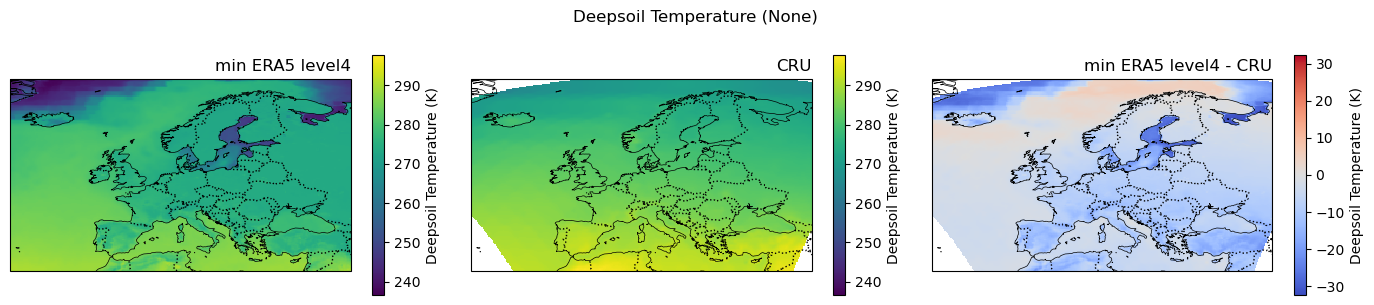

In [ ]:
ax = plot_maps_mod_ref_diff(da_mod = da,  da_ref = da_ec_remap,  da_diff = da_diff)

ValueError: zero-size array to reduction operation fmin which has no identity

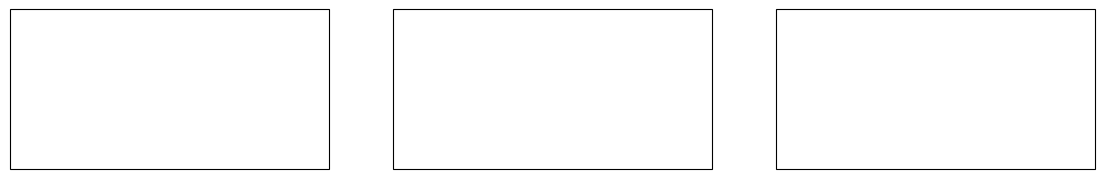

In [ ]:
da_region = sel_region(da, region=region)
da_region
# da_ec_remap_ragion = sel_region(da_ec_remap, region=region)
# da_diff_region = sel_region(da_diff, region=region)

#ax = plot_maps_mod_ref_diff(da_mod = da_region,  da_ref = da_ec_remap_region,  da_diff = da_diff_region)